# Exercise 2

## Data Generation Task

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

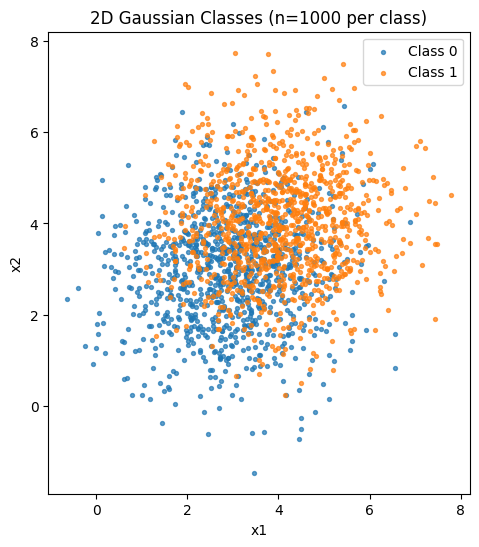

In [88]:
rng = np.random.default_rng(42)

# Parameters
mean0 = np.array([3.0, 3.0])
cov0 = np.array([[1.5, 0.0],
                 [0.0, 1.5]])

mean1 = np.array([4.0, 4.0])
cov1 = np.array([[1.5, 0.0],
                 [0.0, 1.5]])

n_per_class = 1000
 
# Generate data
X0 = rng.multivariate_normal(mean0, cov0, size=n_per_class)
X1 = rng.multivariate_normal(mean1, cov1, size=n_per_class)

# Labels
y0 = np.zeros((n_per_class, 1), dtype=int)
y1 = np.ones((n_per_class, 1), dtype=int)

# Combine
X = np.vstack([X0, X1])
y = np.vstack([y0, y1]).ravel()

plt.figure(figsize=(6, 6))
plt.scatter(X0[:, 0], X0[:, 1], s=8, alpha=0.7, label="Class 0")
plt.scatter(X1[:, 0], X1[:, 1], s=8, alpha=0.7, label="Class 1")
plt.title("2D Gaussian Classes (n=1000 per class)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(loc="best")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

## Perceptron Implementation Task

In [89]:
df = pd.DataFrame({"x1": X[:, 0], "x2": X[:, 1], "label": y})

X = df[["x1", "x2"]].to_numpy(dtype=float)
y01 = df["label"].to_numpy(dtype=int)

# Convert labels {0,1} -> {-1, +1}
y = np.where(y01 == 1, 1, -1)

In [90]:
# Perceptron implementation
class Perceptron:
    def __init__(self, n_features, lr=0.01, max_epochs=100, seed=42):
        self.w = np.zeros(n_features)  
        self.b = 0.0                   
        self.lr = lr
        self.max_epochs = max_epochs
        self.rng = np.random.default_rng(seed)
        self.accuracy_history = []
        self.updates_per_epoch = []
        self.epochs_ran = 0
        self.converged = False

    def _activation(self, z):
        # Sign activation mapping to {-1, +1}. Note: treat 0 as +1 (common in perceptron).
        if z >= 0:
            return 1
        else:
            return -1

    def predict(self, X):
        # Vectorized prediction using sign on w·x + b
        z = X @ self.w + self.b
        return np.array([self._activation(val) for val in z])

    def fit(self, X, y):
        n = X.shape[0]
        indices = np.arange(n)

        for epoch in range(self.max_epochs):
            self.rng.shuffle(indices)
            updates = 0

            # Stochastic perceptron: loop over each sample
            for idx in indices:
                x_i = X[idx]
                y_i = y[idx]
                z = float(self.w @ x_i + self.b)
                y_pred = self._activation(z)
                if y_pred != y_i:
                    # Perceptron update rule
                    self.w = self.w + self.lr * y_i * x_i
                    self.b = self.b + self.lr * y_i
                    updates += 1

            # Track updates and accuracy at end of epoch
            self.updates_per_epoch.append(updates)
            yhat = self.predict(X)
            acc = float((yhat == y).sum()) / float(n)
            self.accuracy_history.append(acc)

            # Check convergence: no updates in full pass
            if updates == 0:
                self.converged = True
                self.epochs_ran = epoch + 1
                break
        else:
            self.epochs_ran = self.max_epochs

        return self

In [91]:
# Train with multiple random initializations to find best performance
num_runs = 5
best_accuracy = 0
best_perceptron = None
all_runs_results = []

for run in range(num_runs):
    # Train with different seed
    perc = Perceptron(n_features=2, lr=0.01, max_epochs=100, seed=run + 7)
    perc.fit(X, y)
    
    # Evaluate
    y_pred = perc.predict(X)
    final_acc = float((y_pred == y).sum()) / float(y.shape[0])
    
    # Store results
    run_result = {
        "run": run + 1,
        "final_accuracy": final_acc,
        "epochs_ran": perc.epochs_ran,
        "converged": perc.converged,
        "total_updates": sum(perc.updates_per_epoch)
    }
    all_runs_results.append(run_result)
    
    # Keep track of best performing model
    if final_acc > best_accuracy:
        best_accuracy = final_acc
        best_perceptron = perc
    
accuracies = [result["final_accuracy"] for result in all_runs_results]
epochs_list = [result["epochs_ran"] for result in all_runs_results]
converged_count = sum([result["converged"] for result in all_runs_results])

# Use best model for further analysis
perc = best_perceptron
y_pred = perc.predict(X)
final_acc = best_accuracy
mis_idx = np.where(y_pred != y)[0]

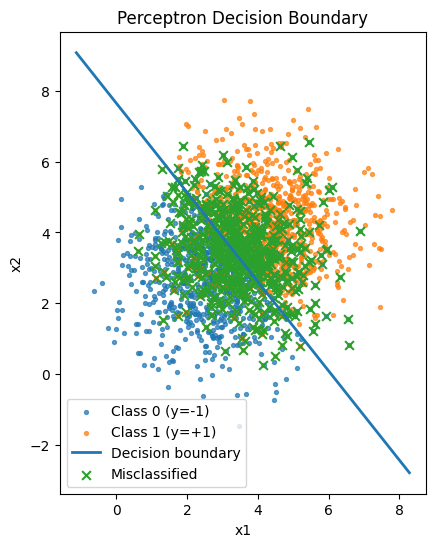

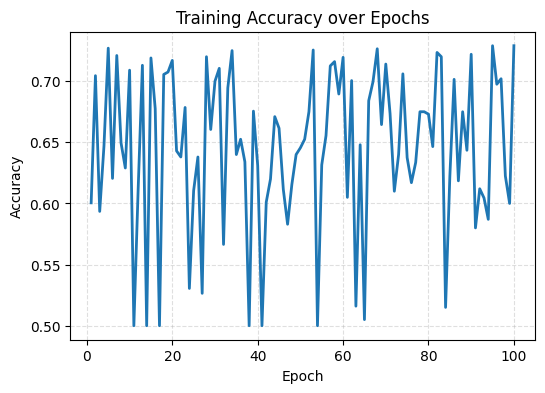

In [92]:
plt.figure(figsize=(6, 6))

# class-wise points
mask0 = y == -1
mask1 = y == 1
plt.scatter(X[mask0, 0], X[mask0, 1], s=8, alpha=0.7, label="Class 0 (y=-1)")
plt.scatter(X[mask1, 0], X[mask1, 1], s=8, alpha=0.7, label="Class 1 (y=+1)")

# Decision boundary: w1*x + w2*y + b = 0 -> x2 = -(w1/w2)*x1 - b/w2, if w2 != 0
x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
xx = np.linspace(x1_min, x1_max, 200)
if abs(perc.w[1]) > 1e-12:
    yy = -(perc.w[0] / perc.w[1]) * xx - (perc.b / perc.w[1])
    plt.plot(xx, yy, linewidth=2, label="Decision boundary")
else:
    # Vertical boundary when w2 == 0: w1*x1 + b = 0 -> x1 = -b / w1
    if abs(perc.w[0]) > 1e-12:
        x_vertical = -perc.b / perc.w[0]
    else:
        x_vertical = 0.0
    plt.axvline(x_vertical, linewidth=2, label="Decision boundary")

# Misclassified points
if mis_idx.size > 0:
    plt.scatter(X[mis_idx, 0], X[mis_idx, 1], s=40, marker="x", label="Misclassified")

plt.title("Perceptron Decision Boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(loc="best")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(perc.accuracy_history) + 1), perc.accuracy_history, linewidth=2)
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

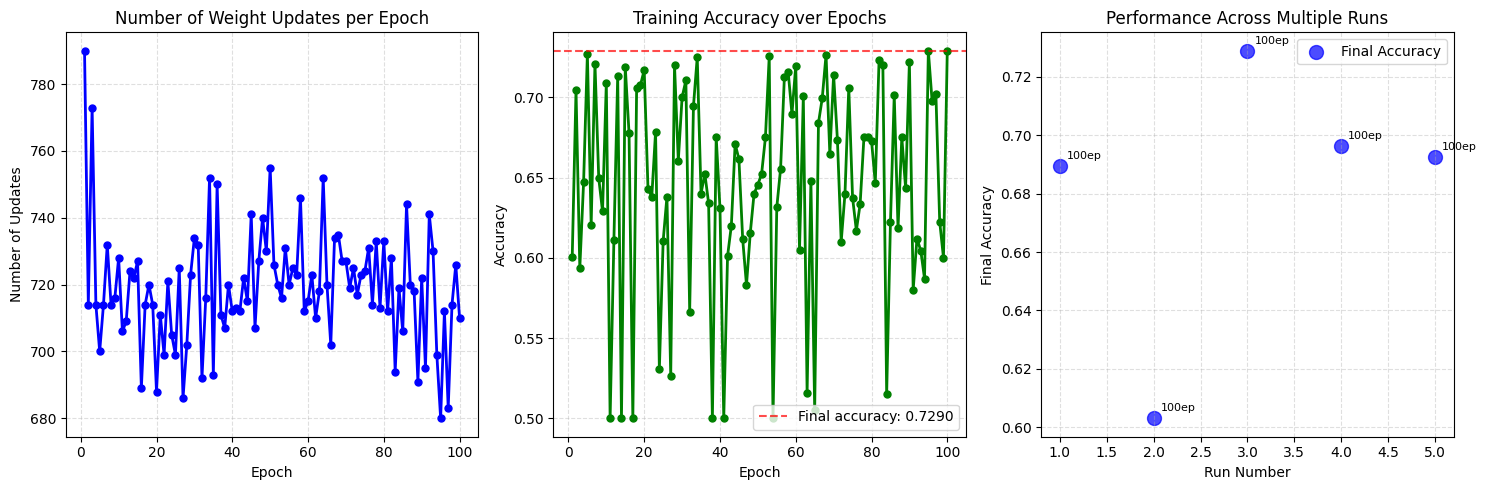

In [93]:
plt.figure(figsize=(15, 5))

# Subplot 1: Updates per epoch
plt.subplot(1, 3, 1)
epochs_range = np.arange(1, len(perc.updates_per_epoch) + 1)
plt.plot(epochs_range, perc.updates_per_epoch, 'bo-', linewidth=2, markersize=5)
plt.title("Number of Weight Updates per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Number of Updates")
plt.grid(True, linestyle="--", alpha=0.4)

if perc.converged:
    plt.axvline(x=perc.epochs_ran, color='red', linestyle='--', alpha=0.7, 
                label=f'Convergence at epoch {perc.epochs_ran}')
    plt.legend()

# Subplot 2: Training accuracy over epochs
plt.subplot(1, 3, 2)
plt.plot(epochs_range, perc.accuracy_history, 'go-', linewidth=2, markersize=5)
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.4)

plt.axhline(y=final_acc, color='red', linestyle='--', alpha=0.7, 
            label=f'Final accuracy: {final_acc:.4f}')
plt.legend()

# Subplot 3: Comparison across multiple runs
plt.subplot(1, 3, 3)
run_numbers = [result["run"] for result in all_runs_results]
run_accuracies = [result["final_accuracy"] for result in all_runs_results]
run_epochs = [result["epochs_ran"] for result in all_runs_results]

plt.scatter(run_numbers, run_accuracies, s=100, c='blue', alpha=0.7, label='Final Accuracy')
plt.title("Performance Across Multiple Runs")
plt.xlabel("Run Number")
plt.ylabel("Final Accuracy")
plt.grid(True, linestyle="--", alpha=0.4)

for i, (acc, epochs) in enumerate(zip(run_accuracies, run_epochs)):
    plt.annotate(f'{epochs}ep', (run_numbers[i], acc), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.legend()
plt.tight_layout()
plt.show()

In [94]:
final_results = {
    "weights": perc.w.tolist(),
    "bias": float(perc.b),
    "epochs_ran": int(perc.epochs_ran),
    "converged": bool(perc.converged),
    "final_accuracy": float(final_acc),
    "num_misclassified": int(mis_idx.size),
}
final_results

{'weights': [0.07578772631189909, 0.060101087921747544],
 'bias': -0.4600000000000002,
 'epochs_ran': 100,
 'converged': False,
 'final_accuracy': 0.729,
 'num_misclassified': 542}